In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
%cd '/content/drive/My Drive/datasets'

/content/drive/.shortcut-targets-by-id/1aN7viA04263ym2FGVc6-TjPVw6-dFv3N/datasets


In [3]:
%ls

angry/  crying/  happy/


In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 400.4MB 35kB/s 
     |████████████████████████████████| 4.0MB 52.8MB/s 
     |████████████████████████████████| 12.2MB 49.7MB/s 
     |████████████████████████████████| 471kB 45.6MB/s 
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip show keras-vggface

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5ar04aoj
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5ar04aoj


In [ ]:
!pip install keras_applications --no-deps
!pip install keras_preprocessing --no-deps
!pip install h5py==2.10.0

     |████████████████████████████████| 51kB 2.5MB/s 


In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 18 19:58:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
dataset_path = "/content/drive/MyDrive/datasets"

data_dir = pathlib.Path(dataset_path)
!ls {data_dir}

angry  crying  happy


In [6]:
#all images count in the dataset
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1800


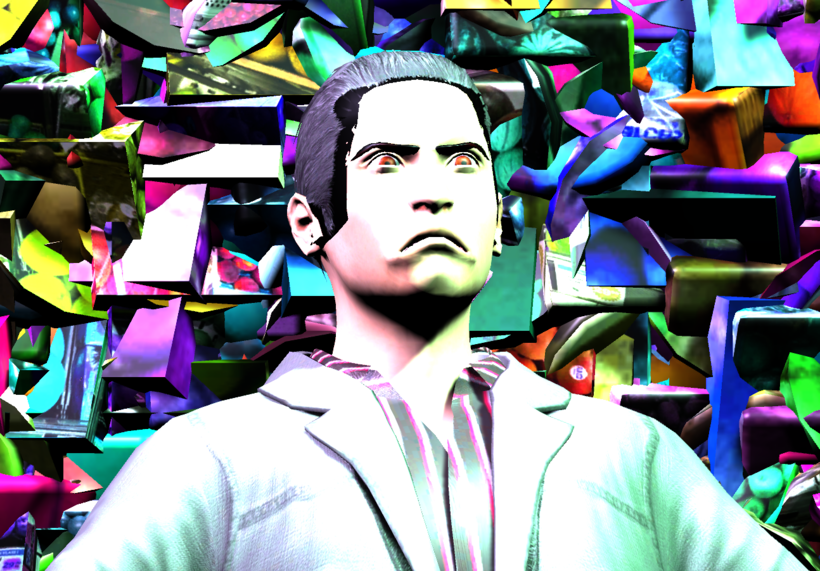

In [7]:
#show first picture in the angry folder
angry_faces = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry_faces[1]))

In [8]:
#define variable for later usage
batch_size = 32
img_height = 224
img_width = 224
image_size = (img_width, img_height)
print(image_size)

(224, 224)


In [9]:
#Spilt train data set from the whole data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 1440 files for training.


In [10]:
#Spilt validation data set from the whole data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 360 files for validation.


In [11]:
#no func
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)

['angry', 'crying', 'happy'] 3


In [12]:
#display some data examples
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
#show validation data set content
for image_batch, labels_batch in val_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('label vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 224, 224, 3)
label vector: tf.Tensor([1 1 3 0 0 0 1 1 3 1 3 1 1 3 3 1 1 1 0 3 3 0 0 3 0 1 3 1 0 0 3 1], shape=(32,), dtype=int32)
labels shape: (32,)


In [ ]:
#show train data set content
for image_batch, labels_batch in train_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('label vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 224, 224, 3)
label vector: tf.Tensor([1 1 0 3 1 0 0 1 1 0 3 1 0 1 3 1 0 0 1 1 3 3 1 1 1 3 3 1 3 1 3 0], shape=(32,), dtype=int32)
labels shape: (32,)


In [13]:
#don't click here twice
#spilt 20% of validation data to test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 10
Number of test batches: 2


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [17]:
# Create the base model from the pre-trained model MobileNet V2
# 3 for RGB color so plue three here
image_shape = image_size + (3,)
print('input size', image_shape, image_size, )
#include_top mean does not know the classisfication layer
base_model = tf.keras.applications.VGG16(input_shape=image_shape, 
                     include_top=False
                     )

input size (224, 224, 3) (224, 224)
58892288/58889256 [==============================] - 1s 0us/step


In [18]:
#No Func, Check example batch only
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [19]:
base_model.trainable = False

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
#first connection layer after the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [22]:
#prediction (output) layer
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [23]:
#define model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = rescale(inputs)
print(x.shape)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
print(outputs.shape)
model = tf.keras.Model(inputs, outputs)
model.summary()

(None, 224, 224, 3)
(None, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_______________

In [24]:
#update binary cross entropy(0 or 1 only)to SparseCategoricalCrossentropy (1 or more classes)
#model.compile() config the model with losses and metrics
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_____________________________________________

In [26]:
len(model.trainable_variables)

2

In [27]:
#check init validation
initial_epochs = 100

loss0, accuracy0 = model.evaluate(val_ds)

10/10 [==============================] - 221s 602ms/step - loss: 1.5868 - accuracy: 0.2925


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.55
initial accuracy: 0.31


In [29]:
#check init validation
initial_epochs = 100
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('./drive/MyDrive/vggFace_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


#train with the datasets
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[es, mc])

Epoch 1/100
45/45 [==============================] - 739s 17s/step - loss: 1.3949 - accuracy: 0.3521 - val_loss: 1.2741 - val_accuracy: 0.3142

Epoch 00001: val_accuracy improved from -inf to 0.31419, saving model to ./drive/MyDrive/vggFace_model.h5
Epoch 2/100
45/45 [==============================] - 45s 869ms/step - loss: 1.2643 - accuracy: 0.3271 - val_loss: 1.1511 - val_accuracy: 0.3209

Epoch 00002: val_accuracy improved from 0.31419 to 0.32095, saving model to ./drive/MyDrive/vggFace_model.h5
Epoch 3/100
45/45 [==============================] - 45s 868ms/step - loss: 1.1976 - accuracy: 0.3125 - val_loss: 1.1115 - val_accuracy: 0.3176

Epoch 00003: val_accuracy did not improve from 0.32095
Epoch 4/100
45/45 [==============================] - 45s 865ms/step - loss: 1.1618 - accuracy: 0.3354 - val_loss: 1.0984 - val_accuracy: 0.3750

Epoch 00004: val_accuracy improved from 0.32095 to 0.37500, saving model to ./drive/MyDrive/vggFace_model.h5
Epoch 5/100
45/45 [=======================

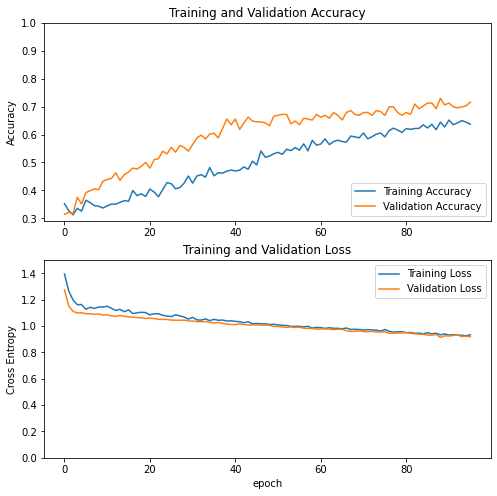

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [33]:
#config the model again with new training parameter
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________

In [35]:
len(model.trainable_variables)

2

In [38]:
print(val_ds)
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[es, mc])
print(history.epoch[-1])

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Epoch 96/200
45/45 [==============================] - 46s 876ms/step - loss: 0.9231 - accuracy: 0.6554 - val_loss: 0.9184 - val_accuracy: 0.7196

Epoch 00096: val_accuracy did not improve from 0.72973
Epoch 97/200
45/45 [==============================] - 45s 870ms/step - loss: 0.9253 - accuracy: 0.6466 - val_loss: 0.9163 - val_accuracy: 0.7027

Epoch 00097: val_accuracy did not improve from 0.72973
Epoch 98/200
45/45 [==============================] - 45s 870ms/step - loss: 0.9237 - accuracy: 0.6590 - val_loss: 0.9139 - val_accuracy: 0.7196

Epoch 00098: val_accuracy did not improve from 0.72973
Epoch 99/200
45/45 [==============================] - 45s 870ms/step - loss: 0.9366 - accuracy: 0.6230 - val_loss: 0.9171 - val_accuracy: 0.7196

Epoch 00099: val_accuracy did not improve from 0.72973
Epoch 100/200
45/45 [==============================] - 46s 873ms/step - loss: 0.9227 - accuracy: 0.6448 - va

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

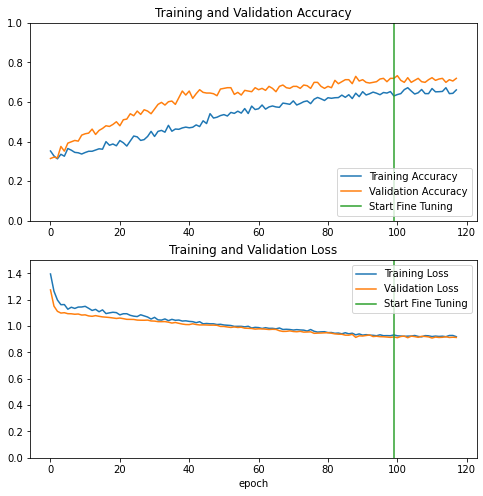

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

2/2 [==============================] - 8s 800ms/step - loss: 0.9353 - accuracy: 0.6562
Test accuracy : 0.65625


Predictions on image :
 32 [[0.2047855  0.2628085  0.532406  ]
 [0.33559313 0.2815478  0.38285905]
 [0.19962496 0.41652966 0.38384542]
 [0.3166323  0.25269037 0.43067732]
 [0.38441715 0.26721227 0.3483706 ]
 [0.3737911  0.43664148 0.1895674 ]
 [0.31739712 0.24886556 0.43373737]
 [0.38667044 0.43905988 0.1742696 ]
 [0.28233215 0.4147647  0.30290318]
 [0.39998955 0.3480456  0.25196487]
 [0.40518782 0.38012385 0.21468835]
 [0.2835772  0.3742001  0.3422227 ]
 [0.41422018 0.35509503 0.23068483]
 [0.38562793 0.3183982  0.2959739 ]
 [0.23062606 0.3123715  0.4570024 ]
 [0.37068078 0.37841558 0.25090367]
 [0.32693243 0.4684211  0.20464644]
 [0.3107079  0.48483822 0.20445381]
 [0.19813669 0.51984984 0.2820135 ]
 [0.3016338  0.33478138 0.3635848 ]
 [0.30600804 0.30666652 0.38732538]
 [0.38589865 0.23138416 0.3827172 ]
 [0.37356794 0.3620512  0.26438084]
 [0.38893405 0.2727367  0.33832926]
 [0.31490755 0.30713204 0.37796038]
 [0.31439322 0.3110709  0.37453583]
 [0.2521871  0.4932054  0.25460744]
 

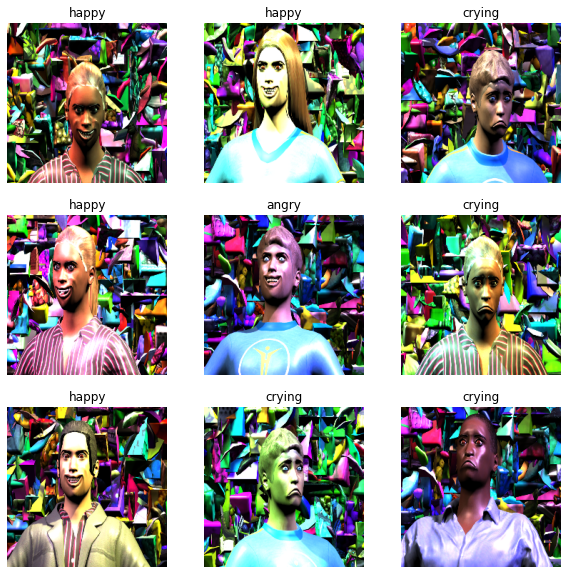

In [42]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('Predictions on image :\n', len(predictions), predictions)

# Apply a soft max since our model returns logits (change to other activaton function)
predictions = tf.nn.softmax(predictions)
print('softmax Predictions:\n', predictions.numpy())

predictions = tf.argmax(predictions, axis=1)

print('Predictions class:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [43]:
model.save('/content/drive/My Drive/vgg16_model.h5')